# QAQC for tanker traffic
- vessel lengths 
- cargo capacities for < 155 m size class  

In [1]:
# import necessary packages
import os
import pandas
import numpy
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path
# import function for querying DOE dataframes
from dask import delayed

# set file location and name
doe_xls_path = Path('/data/MIDOSS/spreadsheets/MuellerTrans4-30-20.xlsx')
fac_xls_path = Path(
    '/home/rmueller/Projects/MIDOSS/marine_transport_data/Oil_Transfer_Facilities.xlsx'
)

# import facility locations
facWA = pandas.read_excel(
    fac_xls_path,
    sheet_name = 'Washington',
    usecols="B,D,J,K"
)

# import facility locations
facCAD = pandas.read_excel(
    fac_xls_path,
    sheet_name = 'British Columbia',
    usecols="A",
    nrows=10
)

In [2]:
def concat_shp(ship_type):
    """
      INPUT: 
          - ship_type ["tanker", "barge", "atb", etc]: MIDOSS-name for ship type (see oil_attribution.yaml for list)
      OUTPUT: 
          - dataframe of all 2018 ship tracks for given ship_type
      requirements: 
          This script requires being run on Salish.eoas.ubc.ca, with path to shapefiles being /data/MIDOSS/shapefiles/
    """
    for months in range(1,13):
        # set file location and name
        shp_path = Path(f'/data/MIDOSS/shapefiles/{ship_type}_2018_{months:02d}.shp')
        # import shapefile using geopandas
        monthly_shp = gpd.read_file(shp_path)
        if months == 1:
            print(f'creating {ship_type} shapefile for 2018, starting with January data')
            allTracks = monthly_shp
        else:
            print(f'Concatenating {ship_type} data from month {months}')
            allTracks = gpd.GeoDataFrame(
                pandas.concat([allTracks, monthly_shp])
            )
    return allTracks

### Concat 2018 tanker traffic AIS

In [5]:
%%time
allTracks={} # adopted from another notebook
ship_type = "tanker"
allTracks["tanker"] = concat_shp("tanker")

creating tanker shapefile for 2018, starting with January data
Concatenating tanker data from month 2
Concatenating tanker data from month 3
Concatenating tanker data from month 4
Concatenating tanker data from month 5
Concatenating tanker data from month 6
Concatenating tanker data from month 7
Concatenating tanker data from month 8
Concatenating tanker data from month 9
Concatenating tanker data from month 10
Concatenating tanker data from month 11
Concatenating tanker data from month 12
CPU times: user 1min 10s, sys: 1.47 s, total: 1min 11s
Wall time: 1min 11s


In [6]:
allTracks["tanker"]["LENGTH"].min()

42

In [7]:
allTracks["tanker"]["LENGTH"].max()

287

In [8]:
allTracks["tanker"].loc[
    allTracks["tanker"]["LENGTH"]==42
]

,MMSI_NUM,ST_DATE,EN_DATE,LENGTH,TO,FROM_,geometry
36833,368009250.0,2018-03-09 17:26:56,2018-03-09 17:28:21,42,None,None,"LINESTRING (-122.36612 47.26532, -122.36500 47..."
36834,368009250.0,2018-03-21 14:15:29,2018-03-21 14:17:05,42,None,None,"LINESTRING (-122.36500 47.26500, -122.36618 47..."
36835,368009250.0,2018-03-21 14:17:53,2018-03-21 14:18:28,42,None,None,"LINESTRING (-122.36618 47.26522, -122.36500 47..."
36836,368009250.0,2018-03-21 14:18:28,2018-03-21 14:20:05,42,None,None,"LINESTRING (-122.36500 47.26500, -122.36618 47..."
36837,368009250.0,2018-03-21 14:20:05,2018-03-21 14:21:29,42,None,None,"LINESTRING (-122.36618 47.26523, -122.36500 47..."
...,...,...,...,...,...,...,...
76024,368009250.0,2018-12-28 23:39:16,2018-12-28 23:39:24,42,Kinder Morgan Liquids Terminal - Harbor Island,Kinder Morgan Liquids Terminal - Harbor Island,"LINESTRING (-122.35268 47.58804, -122.35274 47..."
76025,368009250.0,2018-12-28 23:39:24,2018-12-28 23:40:51,42,Kinder Morgan Liquids Terminal - Harbor Island,Kinder Morgan Liquids Terminal - Harbor Island,"LINESTRING (-122.35274 47.58802, -122.35167 47..."
76026,368009250.0,2018-12-31 16:11:35,2018-12-31 16:16:36,42,None,None,"LINESTRING (-122.35167 47.58667, -122.35238 47..."
76027,368009250.0,2018-12-31 16:16:36,2018-12-31 16:17:35,42,None,None,"LINESTRING (-122.35238 47.58760, -122.35167 47..."


### MMSI 368009250 is for GLOBAL PROVIDER
- Check max fuel transfers to get capacity estimate for this size class (42 feet)

In [9]:
from monte_carlo_utils import get_DOE_df
DOEdf = get_DOE_df(
    doe_xls_path, 
    fac_xls_path,
    group = 'no'
)

In [10]:
GP_df = DOEdf.loc[
    DOEdf.Receiver == 'GLOBAL PROVIDER'
]
GP_df.TransferQtyInGallon.max()

155400.0

### Cargo capacity for Global Provider ~ 155400 Gallons

In [11]:
sm_tankers = allTracks["tanker"].loc[
    allTracks["tanker"]["LENGTH"]<155,
    ['LENGTH','MMSI_NUM']
].groupby('LENGTH').count().sort_values(by='MMSI_NUM',ascending=False).reset_index()
sm_tankers

,LENGTH,MMSI_NUM
0,144,47377
1,153,20356
2,42,19025
3,146,11927
4,152,6652
5,149,6040
6,91,4715
7,145,4299
8,147,2695
9,141,2408


Text(0.5, 0, 'Tanker length (meters)')

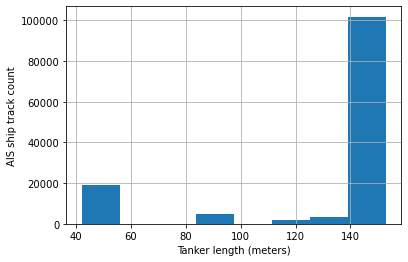

In [12]:
hist=sm_tankers.LENGTH.hist(weights=sm_tankers.MMSI_NUM, bins=8)
hist.set_ylabel('AIS ship track count')
hist.set_xlabel('Tanker length (meters)')

#### create histogram for all tanker lenghts and mmsi

Text(0.5, 0, 'Tanker length (meters)')

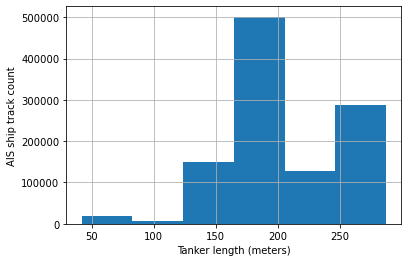

In [13]:
all_tankers = allTracks["tanker"][['LENGTH','MMSI_NUM']].groupby('LENGTH').count().sort_values(by='MMSI_NUM',ascending=False).reset_index()
hist=all_tankers.LENGTH.hist(weights=all_tankers.MMSI_NUM, bins=6)
hist.set_ylabel('AIS ship track count')
hist.set_xlabel('Tanker length (meters)')

In [14]:
all_tankers

,LENGTH,MMSI_NUM
0,183,319343
1,287,78666
2,273,64147
3,182,59741
4,144,47377
...,...,...
59,177,808
60,232,782
61,252,644
62,157,624


In [15]:
allTracks["tanker"][['LENGTH','MMSI_NUM']].groupby('LENGTH').last().sort_values(by='MMSI_NUM',ascending=False).reset_index()

,LENGTH,MMSI_NUM
0,232,636091469.0
1,250,636018579.0
2,183,636018092.0
3,244,636017858.0
4,277,636017061.0
...,...,...
59,275,240546000.0
60,195,238294000.0
61,252,232156000.0
62,176,219124000.0


#### Get representative MMSI for tanker lengths to look up in DOE database

In [16]:
allTracks["tanker"].loc[
    allTracks["tanker"]["LENGTH"]<155,
    ['LENGTH','MMSI_NUM']
].groupby('LENGTH').first()

,MMSI_NUM
LENGTH,
42,368009250.0
89,316041640.0
91,316014610.0
120,212744000.0
127,538006828.0
133,538005277.0
141,371823000.0
144,355320000.0
145,477173600.0


In [17]:
# MMSI 355320000.0 => KIRKEHOLMEN
K_df = DOEdf.loc[
    DOEdf.Receiver == 'KIRKEHOLMEN'
]
K_df.TransferQtyInGallon.max()

3990000.0

### max transfer to Kirkeholmen is 15,103,793.02 liters

In [18]:
tanker_list = DOEdf.loc[
    DOEdf.ReceiverTypeDescription == 'TANK SHIP',
    ['Receiver','ReceiverTypeDescription']
].groupby('Receiver').count().sort_values(by='ReceiverTypeDescription', ascending=False).reset_index()

In [19]:
tanker_list

,Receiver,ReceiverTypeDescription
0,KIRKEHOLMEN,91
1,OVERSEAS LOS ANGELES,76
2,PELICAN STATE,73
3,GLOBAL PROVIDER,37
4,AMERICAN FREEDOM,28
...,...,...
118,CHEMBULK WESTPORT,1
119,POMER,1
120,RS AURORA,1
121,BRITISH CHIEF,1


In [20]:
DOEdf.loc[
    DOEdf.Receiver == 'OVERSEAS LOS ANGELES',
    ['TransferQtyInGallon']
].max()

TransferQtyInGallon    11130000.0
dtype: float64

In [21]:
sf_df = DOEdf.loc[
    DOEdf.Receiver == 'SEAFRIEND'
]
sf_df.TransferQtyInGallon.max()

nan